# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


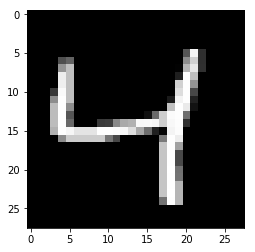

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find with the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

In [7]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='input')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='input')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='SAME')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='SAME')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='SAME')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3, 3), padding='SAME', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [8]:
sess = tf.Session()

In [9]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7062
Epoch: 1/20... Training loss: 0.6997
Epoch: 1/20... Training loss: 0.6952
Epoch: 1/20... Training loss: 0.6922
Epoch: 1/20... Training loss: 0.6902
Epoch: 1/20... Training loss: 0.6886
Epoch: 1/20... Training loss: 0.6873
Epoch: 1/20... Training loss: 0.6860
Epoch: 1/20... Training loss: 0.6847
Epoch: 1/20... Training loss: 0.6831
Epoch: 1/20... Training loss: 0.6814
Epoch: 1/20... Training loss: 0.6794
Epoch: 1/20... Training loss: 0.6771
Epoch: 1/20... Training loss: 0.6742
Epoch: 1/20... Training loss: 0.6705
Epoch: 1/20... Training loss: 0.6669
Epoch: 1/20... Training loss: 0.6614
Epoch: 1/20... Training loss: 0.6560
Epoch: 1/20... Training loss: 0.6484
Epoch: 1/20... Training loss: 0.6399
Epoch: 1/20... Training loss: 0.6303
Epoch: 1/20... Training loss: 0.6191
Epoch: 1/20... Training loss: 0.6054
Epoch: 1/20... Training loss: 0.5905
Epoch: 1/20... Training loss: 0.5761
Epoch: 1/20... Training loss: 0.5607
Epoch: 1/20... Training loss: 0.5426
E

Epoch: 1/20... Training loss: 0.1697
Epoch: 1/20... Training loss: 0.1629
Epoch: 1/20... Training loss: 0.1697
Epoch: 1/20... Training loss: 0.1680
Epoch: 1/20... Training loss: 0.1621
Epoch: 1/20... Training loss: 0.1757
Epoch: 1/20... Training loss: 0.1665
Epoch: 1/20... Training loss: 0.1706
Epoch: 1/20... Training loss: 0.1681
Epoch: 1/20... Training loss: 0.1689
Epoch: 1/20... Training loss: 0.1695
Epoch: 1/20... Training loss: 0.1611
Epoch: 1/20... Training loss: 0.1644
Epoch: 1/20... Training loss: 0.1689
Epoch: 1/20... Training loss: 0.1667
Epoch: 1/20... Training loss: 0.1660
Epoch: 1/20... Training loss: 0.1673
Epoch: 1/20... Training loss: 0.1659
Epoch: 1/20... Training loss: 0.1602
Epoch: 1/20... Training loss: 0.1611
Epoch: 1/20... Training loss: 0.1660
Epoch: 1/20... Training loss: 0.1613
Epoch: 1/20... Training loss: 0.1635
Epoch: 1/20... Training loss: 0.1639
Epoch: 1/20... Training loss: 0.1669
Epoch: 1/20... Training loss: 0.1636
Epoch: 1/20... Training loss: 0.1568
E

Epoch: 2/20... Training loss: 0.1417
Epoch: 2/20... Training loss: 0.1357
Epoch: 2/20... Training loss: 0.1386
Epoch: 2/20... Training loss: 0.1351
Epoch: 2/20... Training loss: 0.1418
Epoch: 2/20... Training loss: 0.1413
Epoch: 2/20... Training loss: 0.1445
Epoch: 2/20... Training loss: 0.1368
Epoch: 2/20... Training loss: 0.1366
Epoch: 2/20... Training loss: 0.1384
Epoch: 2/20... Training loss: 0.1418
Epoch: 2/20... Training loss: 0.1413
Epoch: 2/20... Training loss: 0.1383
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1382
Epoch: 2/20... Training loss: 0.1372
Epoch: 2/20... Training loss: 0.1351
Epoch: 2/20... Training loss: 0.1395
Epoch: 2/20... Training loss: 0.1394
Epoch: 2/20... Training loss: 0.1378
Epoch: 2/20... Training loss: 0.1388
Epoch: 2/20... Training loss: 0.1389
Epoch: 2/20... Training loss: 0.1358
Epoch: 2/20... Training loss: 0.1405
Epoch: 2/20... Training loss: 0.1366
Epoch: 2/20... Training loss: 0.1387
Epoch: 2/20... Training loss: 0.1444
E

Epoch: 3/20... Training loss: 0.1277
Epoch: 3/20... Training loss: 0.1283
Epoch: 3/20... Training loss: 0.1256
Epoch: 3/20... Training loss: 0.1266
Epoch: 3/20... Training loss: 0.1289
Epoch: 3/20... Training loss: 0.1285
Epoch: 3/20... Training loss: 0.1245
Epoch: 3/20... Training loss: 0.1254
Epoch: 3/20... Training loss: 0.1275
Epoch: 3/20... Training loss: 0.1310
Epoch: 3/20... Training loss: 0.1248
Epoch: 3/20... Training loss: 0.1304
Epoch: 3/20... Training loss: 0.1266
Epoch: 3/20... Training loss: 0.1222
Epoch: 3/20... Training loss: 0.1272
Epoch: 3/20... Training loss: 0.1270
Epoch: 3/20... Training loss: 0.1207
Epoch: 3/20... Training loss: 0.1280
Epoch: 3/20... Training loss: 0.1301
Epoch: 3/20... Training loss: 0.1289
Epoch: 3/20... Training loss: 0.1274
Epoch: 3/20... Training loss: 0.1296
Epoch: 3/20... Training loss: 0.1234
Epoch: 3/20... Training loss: 0.1224
Epoch: 3/20... Training loss: 0.1234
Epoch: 3/20... Training loss: 0.1225
Epoch: 3/20... Training loss: 0.1275
E

Epoch: 3/20... Training loss: 0.1176
Epoch: 3/20... Training loss: 0.1187
Epoch: 3/20... Training loss: 0.1234
Epoch: 3/20... Training loss: 0.1184
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1214
Epoch: 3/20... Training loss: 0.1181
Epoch: 3/20... Training loss: 0.1150
Epoch: 3/20... Training loss: 0.1268
Epoch: 3/20... Training loss: 0.1235
Epoch: 3/20... Training loss: 0.1204
Epoch: 3/20... Training loss: 0.1215
Epoch: 4/20... Training loss: 0.1225
Epoch: 4/20... Training loss: 0.1163
Epoch: 4/20... Training loss: 0.1206
Epoch: 4/20... Training loss: 0.1283
Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1199
Epoch: 4/20... Training loss: 0.1169
Epoch: 4/20... Training loss: 0.1177
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1190
Epoch: 4/20... Training loss: 0.1198
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1187
Epoch: 4/20... Training loss: 0.1203
E

Epoch: 4/20... Training loss: 0.1191
Epoch: 4/20... Training loss: 0.1237
Epoch: 4/20... Training loss: 0.1140
Epoch: 4/20... Training loss: 0.1206
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1192
Epoch: 4/20... Training loss: 0.1179
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1146
Epoch: 4/20... Training loss: 0.1159
Epoch: 4/20... Training loss: 0.1117
Epoch: 4/20... Training loss: 0.1168
Epoch: 4/20... Training loss: 0.1110
Epoch: 4/20... Training loss: 0.1185
Epoch: 4/20... Training loss: 0.1150
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1140
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1167
Epoch: 4/20... Training loss: 0.1160
Epoch: 4/20... Training loss: 0.1153
Epoch: 4/20... Training loss: 0.1156
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1189
E

Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1116
Epoch: 5/20... Training loss: 0.1142
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1158
Epoch: 5/20... Training loss: 0.1112
Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1119
Epoch: 5/20... Training loss: 0.1106
Epoch: 5/20... Training loss: 0.1163
Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1176
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1155
Epoch: 5/20... Training loss: 0.1170
Epoch: 5/20... Training loss: 0.1093
Epoch: 5/20... Training loss: 0.1135
Epoch: 5/20... Training loss: 0.1153
Epoch: 5/20... Training loss: 0.1160
Epoch: 5/20... Training loss: 0.1103
Epoch: 5/20... Training loss: 0.1168
Epoch: 5/20... Training loss: 0.1095
Epoch: 5/20... Training loss: 0.1109
Epoch: 5/20... Training loss: 0.1164
Epoch: 5/20... Training loss: 0.1135
Epoch: 5/20... Training loss: 0.1131
Epoch: 5/20... Training loss: 0.1105
E

Epoch: 6/20... Training loss: 0.1139
Epoch: 6/20... Training loss: 0.1147
Epoch: 6/20... Training loss: 0.1107
Epoch: 6/20... Training loss: 0.1134
Epoch: 6/20... Training loss: 0.1130
Epoch: 6/20... Training loss: 0.1108
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1165
Epoch: 6/20... Training loss: 0.1151
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1127
Epoch: 6/20... Training loss: 0.1145
Epoch: 6/20... Training loss: 0.1161
Epoch: 6/20... Training loss: 0.1099
Epoch: 6/20... Training loss: 0.1144
Epoch: 6/20... Training loss: 0.1127
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1140
Epoch: 6/20... Training loss: 0.1118
Epoch: 6/20... Training loss: 0.1167
Epoch: 6/20... Training loss: 0.1080
Epoch: 6/20... Training loss: 0.1120
Epoch: 6/20... Training loss: 0.1122
Epoch: 6/20... Training loss: 0.1151
E

Epoch: 6/20... Training loss: 0.1063
Epoch: 6/20... Training loss: 0.1116
Epoch: 6/20... Training loss: 0.1060
Epoch: 6/20... Training loss: 0.1028
Epoch: 6/20... Training loss: 0.1063
Epoch: 6/20... Training loss: 0.1106
Epoch: 6/20... Training loss: 0.1130
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1094
Epoch: 6/20... Training loss: 0.1118
Epoch: 6/20... Training loss: 0.1133
Epoch: 6/20... Training loss: 0.1113
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1060
Epoch: 6/20... Training loss: 0.1102
Epoch: 6/20... Training loss: 0.1082
Epoch: 6/20... Training loss: 0.1108
Epoch: 6/20... Training loss: 0.1100
Epoch: 6/20... Training loss: 0.1090
Epoch: 6/20... Training loss: 0.1071
Epoch: 6/20... Training loss: 0.1124
Epoch: 6/20... Training loss: 0.1128
Epoch: 6/20... Training loss: 0.1079
Epoch: 6/20... Training loss: 0.1117
Epoch: 7/20... Training loss: 0.1056
Epoch: 7/20... Training loss: 0.1106
Epoch: 7/20... Training loss: 0.1087
E

Epoch: 7/20... Training loss: 0.1147
Epoch: 7/20... Training loss: 0.1095
Epoch: 7/20... Training loss: 0.1112
Epoch: 7/20... Training loss: 0.1073
Epoch: 7/20... Training loss: 0.1070
Epoch: 7/20... Training loss: 0.1107
Epoch: 7/20... Training loss: 0.1137
Epoch: 7/20... Training loss: 0.1105
Epoch: 7/20... Training loss: 0.1083
Epoch: 7/20... Training loss: 0.1141
Epoch: 7/20... Training loss: 0.1035
Epoch: 7/20... Training loss: 0.1089
Epoch: 7/20... Training loss: 0.1132
Epoch: 7/20... Training loss: 0.1046
Epoch: 7/20... Training loss: 0.1061
Epoch: 7/20... Training loss: 0.1065
Epoch: 7/20... Training loss: 0.1061
Epoch: 7/20... Training loss: 0.1100
Epoch: 7/20... Training loss: 0.1044
Epoch: 7/20... Training loss: 0.1054
Epoch: 7/20... Training loss: 0.1100
Epoch: 7/20... Training loss: 0.1055
Epoch: 7/20... Training loss: 0.1089
Epoch: 7/20... Training loss: 0.1040
Epoch: 7/20... Training loss: 0.1082
Epoch: 7/20... Training loss: 0.1053
Epoch: 7/20... Training loss: 0.1084
E

Epoch: 8/20... Training loss: 0.1099
Epoch: 8/20... Training loss: 0.1067
Epoch: 8/20... Training loss: 0.1071
Epoch: 8/20... Training loss: 0.1104
Epoch: 8/20... Training loss: 0.1075
Epoch: 8/20... Training loss: 0.1072
Epoch: 8/20... Training loss: 0.1095
Epoch: 8/20... Training loss: 0.1074
Epoch: 8/20... Training loss: 0.1079
Epoch: 8/20... Training loss: 0.1095
Epoch: 8/20... Training loss: 0.1069
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1055
Epoch: 8/20... Training loss: 0.1086
Epoch: 8/20... Training loss: 0.1077
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1050
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1079
Epoch: 8/20... Training loss: 0.1102
Epoch: 8/20... Training loss: 0.1042
Epoch: 8/20... Training loss: 0.1060
Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1058
Epoch: 8/20... Training loss: 0.1091
Epoch: 8/20... Training loss: 0.1074
E

Epoch: 9/20... Training loss: 0.1069
Epoch: 9/20... Training loss: 0.1025
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1050
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1054
Epoch: 9/20... Training loss: 0.1029
Epoch: 9/20... Training loss: 0.1028
Epoch: 9/20... Training loss: 0.1048
Epoch: 9/20... Training loss: 0.1102
Epoch: 9/20... Training loss: 0.1079
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1092
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1069
Epoch: 9/20... Training loss: 0.1032
Epoch: 9/20... Training loss: 0.1070
Epoch: 9/20... Training loss: 0.1108
Epoch: 9/20... Training loss: 0.1049
Epoch: 9/20... Training loss: 0.1043
Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1080
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1043
Epoch: 9/20... Training loss: 0.1069
Epoch: 9/20... Training loss: 0.1114
Epoch: 9/20... Training loss: 0.1016
E

Epoch: 9/20... Training loss: 0.1055
Epoch: 9/20... Training loss: 0.1052
Epoch: 9/20... Training loss: 0.1034
Epoch: 9/20... Training loss: 0.1070
Epoch: 9/20... Training loss: 0.1083
Epoch: 9/20... Training loss: 0.1073
Epoch: 9/20... Training loss: 0.1105
Epoch: 9/20... Training loss: 0.1082
Epoch: 9/20... Training loss: 0.1049
Epoch: 9/20... Training loss: 0.1003
Epoch: 9/20... Training loss: 0.1041
Epoch: 9/20... Training loss: 0.1047
Epoch: 9/20... Training loss: 0.1037
Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1081
Epoch: 9/20... Training loss: 0.1072
Epoch: 9/20... Training loss: 0.1062
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1029
Epoch: 9/20... Training loss: 0.1009
Epoch: 9/20... Training loss: 0.1039
Epoch: 9/20... Training loss: 0.1038
Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1087
Epoch: 9/20... Training loss: 0.1088
E

Epoch: 10/20... Training loss: 0.1033
Epoch: 10/20... Training loss: 0.1052
Epoch: 10/20... Training loss: 0.1057
Epoch: 10/20... Training loss: 0.1110
Epoch: 10/20... Training loss: 0.1038
Epoch: 10/20... Training loss: 0.1066
Epoch: 10/20... Training loss: 0.1025
Epoch: 10/20... Training loss: 0.1031
Epoch: 10/20... Training loss: 0.1016
Epoch: 10/20... Training loss: 0.1026
Epoch: 10/20... Training loss: 0.0982
Epoch: 10/20... Training loss: 0.1053
Epoch: 10/20... Training loss: 0.1065
Epoch: 10/20... Training loss: 0.1054
Epoch: 10/20... Training loss: 0.1067
Epoch: 10/20... Training loss: 0.1027
Epoch: 10/20... Training loss: 0.1062
Epoch: 10/20... Training loss: 0.1062
Epoch: 10/20... Training loss: 0.1019
Epoch: 10/20... Training loss: 0.1036
Epoch: 10/20... Training loss: 0.1073
Epoch: 10/20... Training loss: 0.1044
Epoch: 10/20... Training loss: 0.1017
Epoch: 10/20... Training loss: 0.1068
Epoch: 10/20... Training loss: 0.1040
Epoch: 10/20... Training loss: 0.1046
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1003
Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.1051
Epoch: 11/20... Training loss: 0.1071
Epoch: 11/20... Training loss: 0.1094
Epoch: 11/20... Training loss: 0.0998
Epoch: 11/20... Training loss: 0.1014
Epoch: 11/20... Training loss: 0.1034
Epoch: 11/20... Training loss: 0.1018
Epoch: 11/20... Training loss: 0.1038
Epoch: 11/20... Training loss: 0.1054
Epoch: 11/20... Training loss: 0.1046
Epoch: 11/20... Training loss: 0.1102
Epoch: 11/20... Training loss: 0.1029
Epoch: 11/20... Training loss: 0.1005
Epoch: 11/20... Training loss: 0.1030
Epoch: 11/20... Training loss: 0.1070
Epoch: 11/20... Training loss: 0.1045
Epoch: 11/20... Training loss: 0.1039
Epoch: 11/20... Training loss: 0.1006
Epoch: 11/20... Training loss: 0.1050
Epoch: 11/20... Training loss: 0.1019
Epoch: 11/20... Training loss: 0.0987
Epoch: 11/20... Training loss: 0.1019
Epoch: 11/20... Training loss: 0.1035
Epoch: 11/20... Training loss: 0.1038
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1061
Epoch: 12/20... Training loss: 0.1026
Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.1027
Epoch: 12/20... Training loss: 0.1037
Epoch: 12/20... Training loss: 0.1010
Epoch: 12/20... Training loss: 0.1072
Epoch: 12/20... Training loss: 0.1059
Epoch: 12/20... Training loss: 0.1038
Epoch: 12/20... Training loss: 0.1053
Epoch: 12/20... Training loss: 0.1067
Epoch: 12/20... Training loss: 0.1044
Epoch: 12/20... Training loss: 0.1054
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.1066
Epoch: 12/20... Training loss: 0.1009
Epoch: 12/20... Training loss: 0.1036
Epoch: 12/20... Training loss: 0.1023
Epoch: 12/20... Training loss: 0.1034
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20... Training loss: 0.1054
Epoch: 12/20... Training loss: 0.0994
Epoch: 12/20... Training loss: 0.1018
Epoch: 12/20... Training loss: 0.1043
Epoch: 12/20... Training loss: 0.1035
Epoch: 12/20... Training loss: 0.1043
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.0992
Epoch: 12/20... Training loss: 0.1015
Epoch: 12/20... Training loss: 0.1045
Epoch: 12/20... Training loss: 0.1038
Epoch: 12/20... Training loss: 0.1073
Epoch: 12/20... Training loss: 0.1000
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20... Training loss: 0.1062
Epoch: 12/20... Training loss: 0.1048
Epoch: 12/20... Training loss: 0.1029
Epoch: 12/20... Training loss: 0.1039
Epoch: 12/20... Training loss: 0.1031
Epoch: 12/20... Training loss: 0.1020
Epoch: 12/20... Training loss: 0.1010
Epoch: 12/20... Training loss: 0.1049
Epoch: 12/20... Training loss: 0.1044
Epoch: 12/20... Training loss: 0.1022
Epoch: 12/20... Training loss: 0.1056
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.1012
Epoch: 12/20... Training loss: 0.1016
Epoch: 12/20... Training loss: 0.0985
Epoch: 12/20... Training loss: 0.1030
Epoch: 12/20... Training loss: 0.1037
Epoch: 12/20... Training loss: 0.1065
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.1012
Epoch: 13/20... Training loss: 0.1026
Epoch: 13/20... Training loss: 0.1039
Epoch: 13/20... Training loss: 0.1039
Epoch: 13/20... Training loss: 0.0987
Epoch: 13/20... Training loss: 0.1029
Epoch: 13/20... Training loss: 0.1045
Epoch: 13/20... Training loss: 0.0980
Epoch: 13/20... Training loss: 0.1050
Epoch: 13/20... Training loss: 0.0986
Epoch: 13/20... Training loss: 0.1048
Epoch: 13/20... Training loss: 0.1050
Epoch: 13/20... Training loss: 0.1040
Epoch: 13/20... Training loss: 0.1012
Epoch: 13/20... Training loss: 0.0988
Epoch: 13/20... Training loss: 0.1040
Epoch: 13/20... Training loss: 0.0999
Epoch: 13/20... Training loss: 0.1014
Epoch: 13/20... Training loss: 0.0995
Epoch: 13/20... Training loss: 0.1023
Epoch: 13/20... Training loss: 0.0984
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.1016
Epoch: 13/20... Training loss: 0.1029
Epoch: 13/20... Training loss: 0.1026
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1028
Epoch: 14/20... Training loss: 0.1019
Epoch: 14/20... Training loss: 0.0990
Epoch: 14/20... Training loss: 0.1048
Epoch: 14/20... Training loss: 0.1010
Epoch: 14/20... Training loss: 0.1013
Epoch: 14/20... Training loss: 0.1027
Epoch: 14/20... Training loss: 0.1008
Epoch: 14/20... Training loss: 0.1053
Epoch: 14/20... Training loss: 0.1012
Epoch: 14/20... Training loss: 0.0996
Epoch: 14/20... Training loss: 0.1002
Epoch: 14/20... Training loss: 0.1014
Epoch: 14/20... Training loss: 0.1049
Epoch: 14/20... Training loss: 0.1037
Epoch: 14/20... Training loss: 0.1019
Epoch: 14/20... Training loss: 0.1042
Epoch: 14/20... Training loss: 0.0999
Epoch: 14/20... Training loss: 0.1023
Epoch: 14/20... Training loss: 0.1006
Epoch: 14/20... Training loss: 0.1029
Epoch: 14/20... Training loss: 0.1043
Epoch: 14/20... Training loss: 0.1048
Epoch: 14/20... Training loss: 0.1004
Epoch: 14/20... Training loss: 0.1001
Epoch: 14/20... Training loss: 0.1026
Epoch: 14/20

Epoch: 14/20... Training loss: 0.0962
Epoch: 14/20... Training loss: 0.1003
Epoch: 14/20... Training loss: 0.1013
Epoch: 14/20... Training loss: 0.1005
Epoch: 14/20... Training loss: 0.1008
Epoch: 14/20... Training loss: 0.1014
Epoch: 14/20... Training loss: 0.1054
Epoch: 14/20... Training loss: 0.0988
Epoch: 14/20... Training loss: 0.1032
Epoch: 14/20... Training loss: 0.1037
Epoch: 14/20... Training loss: 0.1013
Epoch: 14/20... Training loss: 0.1017
Epoch: 14/20... Training loss: 0.0973
Epoch: 14/20... Training loss: 0.1007
Epoch: 14/20... Training loss: 0.1048
Epoch: 14/20... Training loss: 0.0991
Epoch: 14/20... Training loss: 0.1000
Epoch: 14/20... Training loss: 0.0947
Epoch: 14/20... Training loss: 0.1023
Epoch: 14/20... Training loss: 0.1018
Epoch: 14/20... Training loss: 0.1006
Epoch: 14/20... Training loss: 0.0984
Epoch: 14/20... Training loss: 0.0969
Epoch: 15/20... Training loss: 0.1028
Epoch: 15/20... Training loss: 0.1015
Epoch: 15/20... Training loss: 0.1002
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1013
Epoch: 15/20... Training loss: 0.1020
Epoch: 15/20... Training loss: 0.0993
Epoch: 15/20... Training loss: 0.0987
Epoch: 15/20... Training loss: 0.1015
Epoch: 15/20... Training loss: 0.0996
Epoch: 15/20... Training loss: 0.1014
Epoch: 15/20... Training loss: 0.1032
Epoch: 15/20... Training loss: 0.1032
Epoch: 15/20... Training loss: 0.0978
Epoch: 15/20... Training loss: 0.1038
Epoch: 15/20... Training loss: 0.0997
Epoch: 15/20... Training loss: 0.0994
Epoch: 15/20... Training loss: 0.1013
Epoch: 15/20... Training loss: 0.1010
Epoch: 15/20... Training loss: 0.1042
Epoch: 15/20... Training loss: 0.1022
Epoch: 15/20... Training loss: 0.1000
Epoch: 15/20... Training loss: 0.0973
Epoch: 15/20... Training loss: 0.0984
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.1002
Epoch: 15/20... Training loss: 0.1038
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.1003
Epoch: 15/20... Training loss: 0.1021
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0981
Epoch: 16/20... Training loss: 0.0963
Epoch: 16/20... Training loss: 0.1049
Epoch: 16/20... Training loss: 0.0993
Epoch: 16/20... Training loss: 0.1016
Epoch: 16/20... Training loss: 0.1051
Epoch: 16/20... Training loss: 0.1024
Epoch: 16/20... Training loss: 0.1004
Epoch: 16/20... Training loss: 0.0981
Epoch: 16/20... Training loss: 0.0988
Epoch: 16/20... Training loss: 0.1011
Epoch: 16/20... Training loss: 0.0971
Epoch: 16/20... Training loss: 0.1014
Epoch: 16/20... Training loss: 0.0988
Epoch: 16/20... Training loss: 0.1023
Epoch: 16/20... Training loss: 0.1053
Epoch: 16/20... Training loss: 0.0985
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.0994
Epoch: 16/20... Training loss: 0.1012
Epoch: 16/20... Training loss: 0.0995
Epoch: 16/20... Training loss: 0.1004
Epoch: 16/20... Training loss: 0.0982
Epoch: 16/20... Training loss: 0.0986
Epoch: 16/20... Training loss: 0.0985
Epoch: 16/20... Training loss: 0.1010
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1033
Epoch: 17/20... Training loss: 0.1010
Epoch: 17/20... Training loss: 0.0996
Epoch: 17/20... Training loss: 0.0998
Epoch: 17/20... Training loss: 0.1020
Epoch: 17/20... Training loss: 0.1033
Epoch: 17/20... Training loss: 0.0992
Epoch: 17/20... Training loss: 0.1023
Epoch: 17/20... Training loss: 0.0971
Epoch: 17/20... Training loss: 0.0971
Epoch: 17/20... Training loss: 0.1004
Epoch: 17/20... Training loss: 0.0996
Epoch: 17/20... Training loss: 0.0983
Epoch: 17/20... Training loss: 0.0987
Epoch: 17/20... Training loss: 0.1032
Epoch: 17/20... Training loss: 0.1008
Epoch: 17/20... Training loss: 0.0996
Epoch: 17/20... Training loss: 0.1016
Epoch: 17/20... Training loss: 0.1002
Epoch: 17/20... Training loss: 0.1016
Epoch: 17/20... Training loss: 0.0987
Epoch: 17/20... Training loss: 0.1018
Epoch: 17/20... Training loss: 0.1023
Epoch: 17/20... Training loss: 0.1045
Epoch: 17/20... Training loss: 0.1012
Epoch: 17/20... Training loss: 0.1030
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0976
Epoch: 17/20... Training loss: 0.0999
Epoch: 17/20... Training loss: 0.1035
Epoch: 17/20... Training loss: 0.0978
Epoch: 17/20... Training loss: 0.0974
Epoch: 17/20... Training loss: 0.0970
Epoch: 17/20... Training loss: 0.0980
Epoch: 17/20... Training loss: 0.0959
Epoch: 17/20... Training loss: 0.0983
Epoch: 17/20... Training loss: 0.0978
Epoch: 17/20... Training loss: 0.0970
Epoch: 17/20... Training loss: 0.0956
Epoch: 17/20... Training loss: 0.1021
Epoch: 17/20... Training loss: 0.0991
Epoch: 17/20... Training loss: 0.0991
Epoch: 17/20... Training loss: 0.1014
Epoch: 17/20... Training loss: 0.0988
Epoch: 17/20... Training loss: 0.0983
Epoch: 17/20... Training loss: 0.1008
Epoch: 17/20... Training loss: 0.0969
Epoch: 17/20... Training loss: 0.1000
Epoch: 17/20... Training loss: 0.1018
Epoch: 17/20... Training loss: 0.0987
Epoch: 17/20... Training loss: 0.0966
Epoch: 17/20... Training loss: 0.0999
Epoch: 17/20... Training loss: 0.0982
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0988
Epoch: 18/20... Training loss: 0.0996
Epoch: 18/20... Training loss: 0.0992
Epoch: 18/20... Training loss: 0.0980
Epoch: 18/20... Training loss: 0.1004
Epoch: 18/20... Training loss: 0.0978
Epoch: 18/20... Training loss: 0.0990
Epoch: 18/20... Training loss: 0.1023
Epoch: 18/20... Training loss: 0.0980
Epoch: 18/20... Training loss: 0.0981
Epoch: 18/20... Training loss: 0.0970
Epoch: 18/20... Training loss: 0.0991
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.0998
Epoch: 18/20... Training loss: 0.0988
Epoch: 18/20... Training loss: 0.1004
Epoch: 18/20... Training loss: 0.0957
Epoch: 18/20... Training loss: 0.0997
Epoch: 18/20... Training loss: 0.1007
Epoch: 18/20... Training loss: 0.1013
Epoch: 18/20... Training loss: 0.1029
Epoch: 18/20... Training loss: 0.1005
Epoch: 18/20... Training loss: 0.0969
Epoch: 18/20... Training loss: 0.0994
Epoch: 18/20... Training loss: 0.0953
Epoch: 18/20... Training loss: 0.1006
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0999
Epoch: 19/20... Training loss: 0.0979
Epoch: 19/20... Training loss: 0.0982
Epoch: 19/20... Training loss: 0.1024
Epoch: 19/20... Training loss: 0.0976
Epoch: 19/20... Training loss: 0.1017
Epoch: 19/20... Training loss: 0.0983
Epoch: 19/20... Training loss: 0.0964
Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.1028
Epoch: 19/20... Training loss: 0.1001
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0991
Epoch: 19/20... Training loss: 0.0969
Epoch: 19/20... Training loss: 0.0972
Epoch: 19/20... Training loss: 0.1009
Epoch: 19/20... Training loss: 0.0999
Epoch: 19/20... Training loss: 0.0952
Epoch: 19/20... Training loss: 0.1004
Epoch: 19/20... Training loss: 0.0995
Epoch: 19/20... Training loss: 0.1003
Epoch: 19/20... Training loss: 0.1002
Epoch: 19/20... Training loss: 0.1032
Epoch: 19/20... Training loss: 0.0999
Epoch: 19/20... Training loss: 0.0984
Epoch: 19/20... Training loss: 0.1012
Epoch: 19/20

Epoch: 19/20... Training loss: 0.0958
Epoch: 19/20... Training loss: 0.0997
Epoch: 19/20... Training loss: 0.0967
Epoch: 19/20... Training loss: 0.0998
Epoch: 19/20... Training loss: 0.1000
Epoch: 19/20... Training loss: 0.0981
Epoch: 19/20... Training loss: 0.0969
Epoch: 19/20... Training loss: 0.0982
Epoch: 19/20... Training loss: 0.1018
Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.0969
Epoch: 20/20... Training loss: 0.0946
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0971
Epoch: 20/20... Training loss: 0.0996
Epoch: 20/20... Training loss: 0.1012
Epoch: 20/20... Training loss: 0.1009
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.1002
Epoch: 20/20... Training loss: 0.0995
Epoch: 20/20... Training loss: 0.0986
Epoch: 20/20... Training loss: 0.1008
Epoch: 20/20... Training loss: 0.0987
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0974
Epoch: 20/20... Training loss: 0.0965
Epoch: 20/20... Training loss: 0.1011
Epoch: 20/20... Training loss: 0.0994
Epoch: 20/20... Training loss: 0.0967
Epoch: 20/20... Training loss: 0.0992
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0959
Epoch: 20/20... Training loss: 0.0958
Epoch: 20/20... Training loss: 0.0986
Epoch: 20/20... Training loss: 0.0983
Epoch: 20/20... Training loss: 0.0976
Epoch: 20/20... Training loss: 0.0995
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20... Training loss: 0.1023
Epoch: 20/20... Training loss: 0.1032
Epoch: 20/20... Training loss: 0.0949
Epoch: 20/20... Training loss: 0.0955
Epoch: 20/20... Training loss: 0.1020
Epoch: 20/20... Training loss: 0.0974
Epoch: 20/20... Training loss: 0.1015
Epoch: 20/20... Training loss: 0.1004
Epoch: 20/20... Training loss: 0.1013
Epoch: 20/20... Training loss: 0.1008
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.0947
Epoch: 20/20

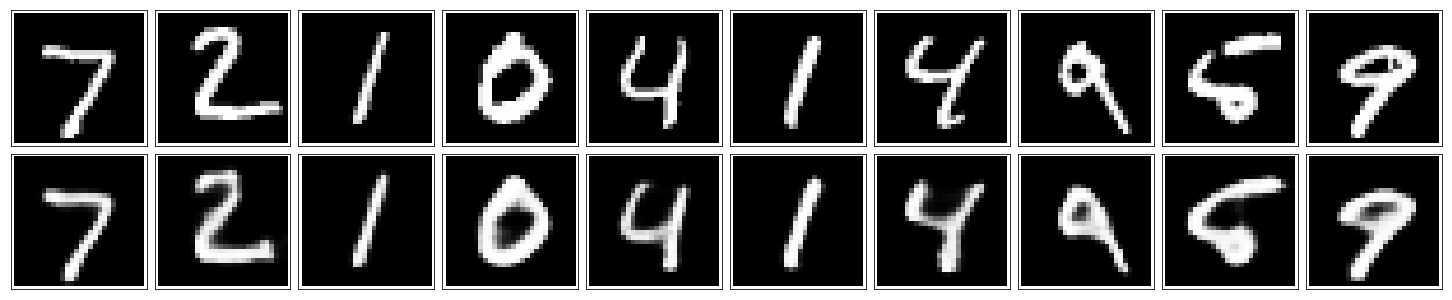

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [11]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [18]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='SAME')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='SAME')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='SAME')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3, 3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3, 3), padding='SAME', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [19]:
sess = tf.Session()

In [20]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6880
Epoch: 1/100... Training loss: 0.6543
Epoch: 1/100... Training loss: 0.6103
Epoch: 1/100... Training loss: 0.5615
Epoch: 1/100... Training loss: 0.5164
Epoch: 1/100... Training loss: 0.5033
Epoch: 1/100... Training loss: 0.5226
Epoch: 1/100... Training loss: 0.5258
Epoch: 1/100... Training loss: 0.5327
Epoch: 1/100... Training loss: 0.5014
Epoch: 1/100... Training loss: 0.4816
Epoch: 1/100... Training loss: 0.4752
Epoch: 1/100... Training loss: 0.4741
Epoch: 1/100... Training loss: 0.4862
Epoch: 1/100... Training loss: 0.4736
Epoch: 1/100... Training loss: 0.4673
Epoch: 1/100... Training loss: 0.4475
Epoch: 1/100... Training loss: 0.4479
Epoch: 1/100... Training loss: 0.4410
Epoch: 1/100... Training loss: 0.4226
Epoch: 1/100... Training loss: 0.4029
Epoch: 1/100... Training loss: 0.4134
Epoch: 1/100... Training loss: 0.3956
Epoch: 1/100... Training loss: 0.3895
Epoch: 1/100... Training loss: 0.3846
Epoch: 1/100... Training loss: 0.3732
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1793
Epoch: 1/100... Training loss: 0.1796
Epoch: 1/100... Training loss: 0.1798
Epoch: 1/100... Training loss: 0.1817
Epoch: 1/100... Training loss: 0.1765
Epoch: 1/100... Training loss: 0.1808
Epoch: 1/100... Training loss: 0.1762
Epoch: 1/100... Training loss: 0.1798
Epoch: 1/100... Training loss: 0.1801
Epoch: 1/100... Training loss: 0.1773
Epoch: 1/100... Training loss: 0.1829
Epoch: 1/100... Training loss: 0.1801
Epoch: 1/100... Training loss: 0.1775
Epoch: 1/100... Training loss: 0.1805
Epoch: 1/100... Training loss: 0.1803
Epoch: 1/100... Training loss: 0.1767
Epoch: 1/100... Training loss: 0.1824
Epoch: 1/100... Training loss: 0.1792
Epoch: 1/100... Training loss: 0.1788
Epoch: 1/100... Training loss: 0.1812
Epoch: 1/100... Training loss: 0.1859
Epoch: 1/100... Training loss: 0.1776
Epoch: 1/100... Training loss: 0.1712
Epoch: 1/100... Training loss: 0.1784
Epoch: 1/100... Training loss: 0.1791
Epoch: 1/100... Training loss: 0.1789
Epoch: 1/100

KeyboardInterrupt: 

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

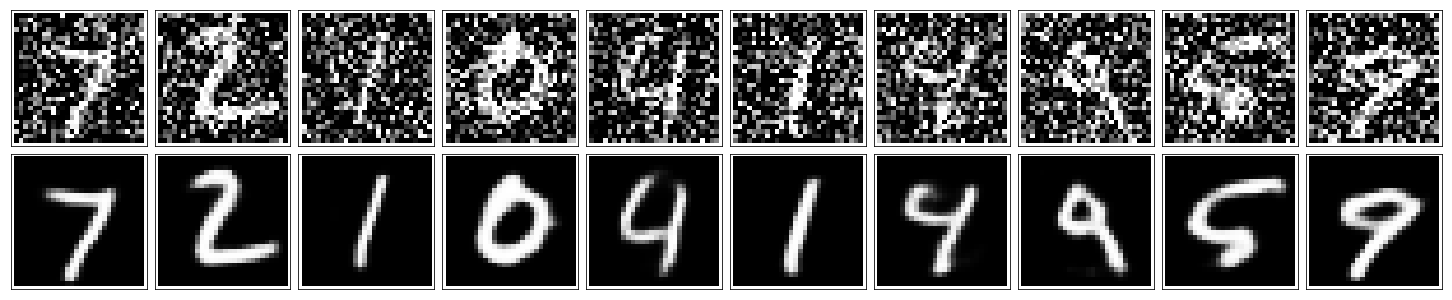

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)